<b><font size="6">New York City Taxi Fare Prediction Playground Competition</br>
    Data Wrangling</font></b>

**PDS ILV bds19: Summer School**  
**Data Science & Business Analytics**

Autor: Thomas Schrittwieser, DS191004  
Datum: 2020-07-20

---

In [1]:
# load some default Python modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('seaborn')

## Configuration

In [50]:
# Configuration

show_maps = 0         # If you want to see the maps, choose show_maps = 1 
show_diagrams = 1     # If you want to see the diagrams, choose show_diagrams = 1
random_sample_df = 0  # If you want to work with a sample dataframe, choose random_sample_df = 1
write_to_feather = 0  # If you want to store the cleaned dataframe as feather file, choose write_to_feather = 1

# input filename
input_file = '../data/new-york-city-taxi-fare-prediction/nyc_taxi_data_raw.feather'

# output filename
output_file = '../data/new-york-city-taxi-fare-prediction/nyc_taxi_data_cleaned.feather'

# Reading data and first exploration

In [3]:
# load the feather-file with the taxi data which was created in file '1_CSV2Feather.ipynb'
df = pd.read_feather(input_file)

In [4]:
# Create a random sample dataframe with 2_000_000 elements
if random_sample_df == 1:
    df = df.sample(n=5_000_000, random_state=1)

# Save the shape of the initial dataframe for further use
df_initial_shape = df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55423856 entries, 0 to 55423855
Data columns (total 7 columns):
 #   Column             Dtype              
---  ------             -----              
 0   fare_amount        float32            
 1   pickup_datetime    datetime64[ns, UTC]
 2   pickup_longitude   float32            
 3   pickup_latitude    float32            
 4   dropoff_longitude  float32            
 5   dropoff_latitude   float32            
 6   passenger_count    uint8              
dtypes: datetime64[ns, UTC](1), float32(5), uint8(1)
memory usage: 1.5 GB


In [5]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:00+00:00,-73.844315,40.721317,-73.841614,40.712276,1
1,16.9,2010-01-05 16:52:00+00:00,-74.016045,40.711304,-73.979271,40.782005,1
2,5.7,2011-08-18 00:35:00+00:00,-73.982735,40.761269,-73.991241,40.750561,2
3,7.7,2012-04-21 04:30:00+00:00,-73.987129,40.733143,-73.991570,40.758091,1
4,5.3,2010-03-09 07:51:00+00:00,-73.968094,40.768009,-73.956657,40.783764,1


In [6]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5.542386e+07,5.542386e+07,5.542386e+07,5.542348e+07,5.542348e+07,5.542386e+07
mean,8.077921e+00,-3.875290e+01,1.937328e+01,-3.875261e+01,1.937341e+01,1.685380e+00
std,2.055127e+01,2.556202e+01,1.414234e+01,2.553839e+01,1.412191e+01,1.327664e+00
min,-3.000000e+02,-3.442060e+03,-3.492264e+03,-3.442025e+03,-3.547887e+03,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073493e+01,-7.399140e+01,4.073403e+01,1.000000e+00
50%,8.500000e+00,-7.398180e+01,4.075265e+01,-7.398015e+01,4.075316e+01,1.000000e+00
75%,1.250000e+01,-7.396708e+01,4.076713e+01,-7.396368e+01,4.076810e+01,2.000000e+00
max,9.396336e+04,3.457626e+03,3.408790e+03,3.457622e+03,3.537133e+03,2.080000e+02


The following things I notice:

- The minimal `fare_amount` is negative. The initial charge is $\$2.5$ USD (https://www1.nyc.gov/site/tlc/passengers/taxi-fare.page).  
  Fare amounts under $\$2.5$ USD does not seem to be realistic. I will drop them from the data
- The average `fare_amount` is about $\$11.4$ USD with a standard deviation of $\$9.9$ USD. When building a predictive model we want to be better than $\$9.9$ USD.
- Some of the minimum and maximum longitude/lattitude coordinates are way off. These I will also remove from the dataset with a bounding box for the coordinates.
- The maximum `passenger_count` is very high. As this does not seem to be realistic I will drop them from the dataset.  
  [NYC Passengers FAQ](https://www1.nyc.gov/site/tlc/passengers/passenger-frequently-asked-questions.page): *The maximum amount of passengers allowed in a yellow taxicab by law is four (4) in a four (4) passenger taxicab or five (5) passengers in a five (5) passenger taxicab, except that an additional passenger must be accepted if such passenger is under the age of seven (7) and is held on the lap of an adult passenger seated in the rear.*

# Remove missing data

In [7]:
# Check for null-values in the DataFrame
df.isnull().sum()

fare_amount            0
pickup_datetime        0
pickup_longitude       0
pickup_latitude        0
dropoff_longitude    376
dropoff_latitude     376
passenger_count        0
dtype: int64

In [8]:
# Check for null-values in the DataFrame
print('Number of columns with missing values: ' + str(df.isnull().any().sum()) + '\n')

# Create dataframe with the absolute and relative number of null values
missing_values = pd.DataFrame(df.isnull().sum().sort_values(ascending=False))
missing_values.index.names = ['Columns with missing values']
missing_values.rename(columns={0: 'Abs. Count'}, inplace = True)
missing_values['Rel. Count'] = missing_values['Abs. Count'] / len(df)
missing_values[missing_values['Abs. Count']>0]

Number of columns with missing values: 2



,Abs. Count,Rel. Count
Columns with missing values,,
dropoff_latitude,376,0.000007
dropoff_longitude,376,0.000007


In relative terms, the number of missing values is so small that they can be dropped.

In [9]:
# Function for the output of the data frame manipulation
def output_data_manipulation(df_len_old, df_len_new):
    str_len = len(str(df_len_old))
    deleted = df_len_old - df_len_new
    deleted = str(deleted).rjust(str_len+1)
    print('Data frame manipulation:\n')
    print(f'  Old size: {df_len_old}')
    print(f'  Deleted: ' + deleted)
    print('  ' + '-'*(10+str_len))
    print(f'  New size: {df_len_new}')

In [10]:
# Drop all NAs
df_len_old = df.shape[0]
df.dropna(inplace=True)
df_len_new = df.shape[0]

output_data_manipulation(df_len_old, df_len_new)

Data frame manipulation:

  Old size: 55423856
  Deleted:       376
  ------------------
  New size: 55423480


# Remove values that not seem to be realistic

## Fare amount

In [11]:
df['fare_amount'].describe()

count    5.542348e+07
mean     8.077908e+00
std      2.055130e+01
min     -3.000000e+02
25%      6.000000e+00
50%      8.500000e+00
75%      1.250000e+01
max      9.396336e+04
Name: fare_amount, dtype: float64

- The minimal `fare_amount` is negative.
- The initial charge is $\$2.5$ USD (https://www1.nyc.gov/site/tlc/passengers/taxi-fare.page).
- Fare amounts under $\$2.5$ USD does not seem to be realistic. I will drop them from the dataset.

In [12]:
# Drop all instances with fare amount < 2.5
df_len_old = df.shape[0]
df = df[df['fare_amount'] >= 2.5]
df_len_new = df.shape[0]

output_data_manipulation(df_len_old, df_len_new)

Data frame manipulation:

  Old size: 55423480
  Deleted:      4747
  ------------------
  New size: 55418733


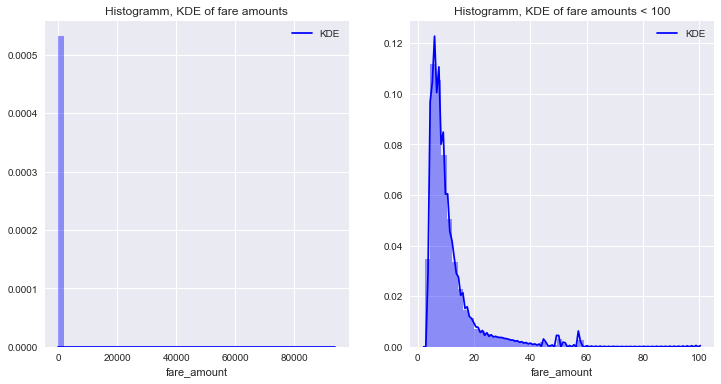

In [13]:
# Histogramm & KDE of fare_amounts
if show_diagrams == 1:
    hist_max_fare_amount = 100

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    sns.distplot(df['fare_amount'], 
                 color="b", 
                 kde_kws={"label": "KDE"}, 
                 ax=ax1)
    ax1.set_title('Histogramm, KDE of fare amounts');
    sns.distplot(df[df['fare_amount']<hist_max_fare_amount]['fare_amount'], 
                 color="b", 
                 kde_kws={"label": "KDE"}, 
                 ax=ax2)
    ax2.set_title(f'Histogramm, KDE of fare amounts < {hist_max_fare_amount}');

In the histogram of the `fare_amount` there are some small spikes between $\$40$ and $\$60$. This could indicate some fixed fare price e.g. to/from airport (https://www1.nyc.gov/site/tlc/passengers/taxi-fare.page).

In [14]:
# Number of fare amounts higher or equal 100 USD
(df['fare_amount']>=100).sum()

22899

## Passenger count

In [15]:
df['passenger_count'].describe()

count    5.541873e+07
mean     1.685395e+00
std      1.327668e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      2.080000e+02
Name: passenger_count, dtype: float64

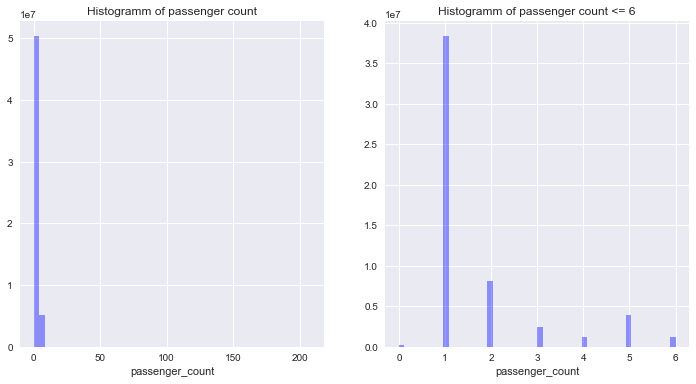

In [16]:
# Histogramm of passenger count
if show_diagrams == 1:
    hist_max_passenger_count = 6

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    sns.distplot(df['passenger_count'], 
                 color="b", 
                 kde = False,  
                 ax=ax1)
    ax1.set_title('Histogramm of passenger count')
    sns.distplot(df[df['passenger_count']<=hist_max_passenger_count]['passenger_count'], 
                 color="b", 
                 kde=False,
                 ax = ax2)
    ax2.set_title(f'Histogramm of passenger count <= {hist_max_passenger_count}');

- The maximum `passenger_count` is very high. The maximum amount of passengers allowed in a yellow taxicab by law is four (4) in a four (4) passenger taxicab or five (5) passengers in a five (5) passenger taxicab, except that an additional passenger must be accepted if such passenger is under the age of seven (7) and is held on the lap of an adult passenger seated in the rear.  
  So, the maximum amount of passengers is six (6).
- Trips with zero passengers could be freight trips. These trips have no relevant information for us.
- So I drop all trips with a `passenger_count` higher than 6 and a `passenger_count` equal to zero.

In [17]:
# Drop passenger count = 0 and passenger count > 6
df_len_old = df.shape[0]
df = df[(df['passenger_count']>0) & (df['passenger_count']<7)]
df_len_new = df.shape[0]

output_data_manipulation(df_len_old, df_len_new)

Data frame manipulation:

  Old size: 55418733
  Deleted:    195109
  ------------------
  New size: 55223624


## Location data

New York city coordinates are (https://www.travelmath.com/cities/New+York,+NY):

- longitude = -74.0063889
- lattitude = 40.7141667

I define a bounding box of interest by [long_min, long_max, latt_min, latt_max] using the minimum and maximum coordinates from the testset. This way, I'm sure to train a model for the full pickup/dropoff coordinate range of the test set.

In [18]:
# this function will also be used with the test set below
def select_within_boundingbox(df, BB):
    return (df.pickup_longitude >= BB[0]) & (df.pickup_longitude <= BB[1]) & \
           (df.pickup_latitude >= BB[2]) & (df.pickup_latitude <= BB[3]) & \
           (df.dropoff_longitude >= BB[0]) & (df.dropoff_longitude <= BB[1]) & \
           (df.dropoff_latitude >= BB[2]) & (df.dropoff_latitude <= BB[3])
            
# load image of NYC map
BB = (-74.5, -72.8, 40.5, 41.8)
nyc_map = plt.imread('https://aiblog.nl/download/nyc_-74.5_-72.8_40.5_41.8.png')

# load extra image to zoom in on NYC
BB_zoom = (-74.3, -73.7, 40.5, 40.9)
nyc_map_zoom = plt.imread('https://aiblog.nl/download/nyc_-74.3_-73.7_40.5_40.9.png')

In [19]:
# Drop all instances outside the bounding box
df_len_old = df.shape[0]
df = df[select_within_boundingbox(df, BB)]
df_len_new = df.shape[0]

output_data_manipulation(df_len_old, df_len_new)

Data frame manipulation:

  Old size: 55223624
  Deleted:   1169526
  ------------------
  New size: 54054098


In [20]:
# this function will be used more often to plot data on the NYC map
def plot_on_map(df, BB, nyc_map, s=10, alpha=0.2):
    fig, axs = plt.subplots(1, 2, figsize=(16,10))
    axs[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].set_title('Pickup locations')
    axs[0].imshow(nyc_map, zorder=0, extent=BB)

    axs[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].set_title('Dropoff locations')
    axs[1].imshow(nyc_map, zorder=0, extent=BB)

In [21]:
# plot data on map
if show_maps == 1:
    plot_on_map(df, BB, nyc_map, s=1, alpha=0.3)

In [22]:
# plot data on map zoomed in
if show_maps == 1:
    plot_on_map(df, BB_zoom, nyc_map_zoom, s=1, alpha=0.3)

From the scatter plot we see that some locations are in the water. Either these are considered as noise, or we drop them from the dataset. I decided to drop them.

## Removing datapoints in water
As can be seen from the map + scatter plots above, some datapoints are located in the water. These are obviously noisy datapoints. To remove these datapoints, I create a boolean land/water map from the NYC map. For this I used Photoshop to threshold on the blue color of the water and to cleanup the map.

In [23]:
def remove_datapoints_from_water(df):
    def lonlat_to_xy(longitude, latitude, dx, dy, BB):
        return (dx*(longitude - BB[0])/(BB[1]-BB[0])).astype('int'), \
               (dy - dy*(latitude - BB[2])/(BB[3]-BB[2])-1).astype('int')

    # define bounding box
    BB = (-74.5, -72.8, 40.5, 41.8)
    
    # read nyc mask and turn into boolean map with
    # land = True, water = False
    nyc_mask = plt.imread('https://aiblog.nl/download/nyc_mask-74.5_-72.8_40.5_41.8.png')[:,:,0] > 0.9
    
    # calculate for each lon,lat coordinate the xy coordinate in the mask map
    pickup_x, pickup_y = lonlat_to_xy(df.pickup_longitude, df.pickup_latitude, 
                                      nyc_mask.shape[1], nyc_mask.shape[0], BB)
    dropoff_x, dropoff_y = lonlat_to_xy(df.dropoff_longitude, df.dropoff_latitude, 
                                      nyc_mask.shape[1], nyc_mask.shape[0], BB)    
    # calculate boolean index
    idx = nyc_mask[pickup_y, pickup_x] & nyc_mask[dropoff_y, dropoff_x]
    
    # return only datapoints on land
    return df[idx]

In [24]:
# remove datapoints from water
df_len_old = df.shape[0]
df = remove_datapoints_from_water(df)
df_len_new = df.shape[0]

output_data_manipulation(df_len_old, df_len_new)

Data frame manipulation:

  Old size: 54054098
  Deleted:     10949
  ------------------
  New size: 54043149


# Remove zero values

Are there columns with a minimum value of zero? On some columns, a value of zero does not make sense and indicates an invalid or missing value.

In [25]:
num_columns = df.select_dtypes(include=np.number).columns.tolist()
(df[num_columns]==0).sum().sort_values(ascending=False)

passenger_count      0
dropoff_latitude     0
dropoff_longitude    0
pickup_latitude      0
pickup_longitude     0
fare_amount          0
dtype: int64

# Calculate the distance

In [26]:
# For this plot and further analysis, we need a function to calculate the distance in miles between locations in lon,lat coordinates.
# This function is based on https://stackoverflow.com/questions/27928/
# calculate-distance-between-two-latitude-longitude-points-haversine-formula 
# return distance in miles
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a)) # 2*R*asin...

In [27]:
# Calculate the distance
df['distance'] = distance(df['pickup_latitude'], df['pickup_longitude'], df['dropoff_latitude'], df['dropoff_longitude']).astype('float32')
df['distance'].describe()

count    5.404315e+07
mean     1.567385e+00
std      2.263958e+00
min      0.000000e+00
25%      7.789605e-01
50%      1.338039e+00
75%      2.430295e+00
max      8.937457e+01
Name: distance, dtype: float64

- There are some trips with a distance of zero. These trips could be round trips and have no information for us. So I will drop them.

In [28]:
# Drop trips with a distance of zero
df_len_old = df.shape[0]
df = df[df['distance']!=0]
df_len_new = df.shape[0]

output_data_manipulation(df_len_old, df_len_new)

Data frame manipulation:

  Old size: 54043149
  Deleted:    582165
  ------------------
  New size: 53460984


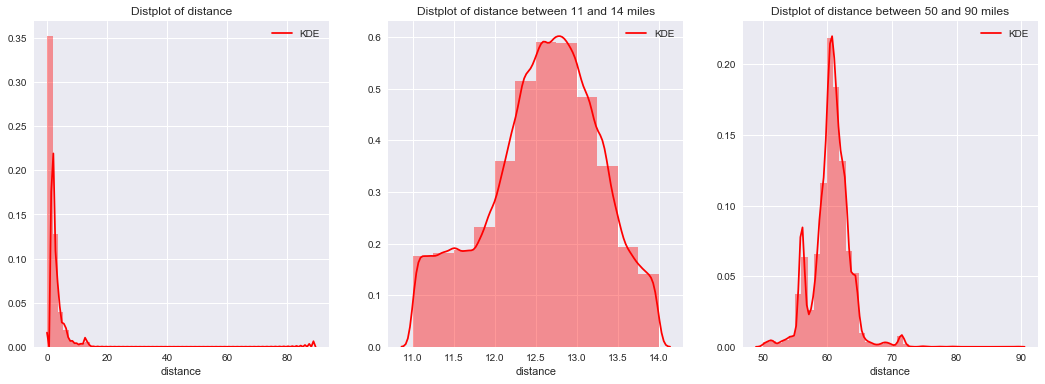

In [29]:
# Distplot of distance
if show_diagrams == 1:
    dist_min1 = 11
    dist_max1 = 14
    dist_min2 = 50
    dist_max2 = 90

    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(18,6))
    sns.distplot(df['distance'], 
                 color="r",
                 kde_kws={"label": "KDE"},
                 ax=ax1)
    ax1.set_title('Distplot of distance')
    sns.distplot(df[(df['distance']>dist_min1) & (df['distance']<dist_max1)]['distance'], 
                 color="r",
                 kde_kws={"label": "KDE"},
                 bins = (dist_max1 - dist_min1)*4,
                 ax=ax2)
    ax2.set_title(f'Distplot of distance between {dist_min1} and {dist_max1} miles')
    sns.distplot(df[(df['distance']>dist_min2) & (df['distance']<dist_max2)]['distance'], 
                 color="r",
                 kde_kws={"label": "KDE"},
                 bins = (dist_max2 - dist_min2),
                 ax=ax3)
    ax3.set_title(f'Distplot of distance between {dist_min2} and {dist_max2} miles');

Notice the peaks at ~13 miles and ~70 miles.

# Calculate price/mile

In [30]:
# Calculate the price/mile
df['price/mile'] = df['fare_amount']/df['distance'].astype('float32')
df['price/mile'].describe()

count    5.346098e+07
mean     6.614342e+01
std      3.049442e+03
min      3.498168e-02
25%      4.776332e+00
50%      6.150697e+00
75%      8.134265e+00
max      1.891502e+06
Name: price/mile, dtype: float64

- The average price per mile is about 3.3 USD (https://www.numbeo.com/taxi-fare/in/New-York).  
- The distance between the pick-up and drop-off points in this data set is calculated as the air line distance. The actual distance between two points is therefore equal to or higher than the calculated air-line distance. Therefore prices per mile well below 3 USD may not be possible. So I will drop all prices/mile below 2 USD.

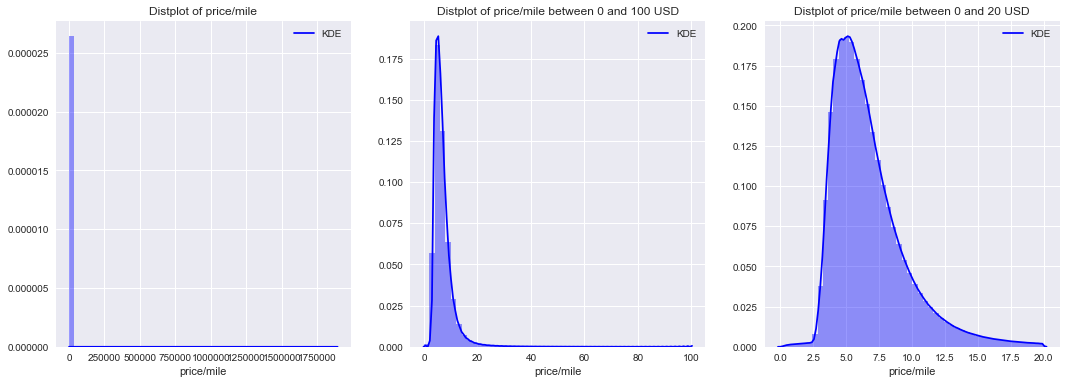

In [31]:
# Distplot of price/mile
if show_diagrams == 1:
    pricemile_min1 = 0
    pricemile_max1 = 100
    pricemile_min2 = 0
    pricemile_max2 = 20

    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(18,6))
    sns.distplot(df['price/mile'],
                 color="b",
                 kde_kws={"label": "KDE"},
                 ax=ax1)
    ax1.set_title('Distplot of price/mile')
    sns.distplot(df[(df['price/mile']>pricemile_min1) & (df['price/mile']<pricemile_max1)]['price/mile'], 
                 color="b",
                 kde_kws={"label": "KDE"},
                 ax=ax2)
    ax2.set_title(f'Distplot of price/mile between {pricemile_min1} and {pricemile_max1} USD')
    sns.distplot(df[(df['price/mile']>pricemile_min2) & (df['price/mile']<pricemile_max2)]['price/mile'], 
                 color="b",
                 kde_kws={"label": "KDE"},
                 ax=ax3)
    ax3.set_title(f'Distplot of price/mile between {pricemile_min2} and {pricemile_max2} USD');

- As you can see in the distplot above, the range of price/mile is between 2 and 20 USD.

In [32]:
sum_lower2 = (df['price/mile']<2).sum()
sum_higher20 = (df['price/mile']>=20).sum()

print(f'Number of instances with a price/mile lower 2 USD:   {sum_lower2}')
print(f'Number of instances with a price/mile higher 20 USD: {sum_higher20}')

Number of instances with a price/mile lower 2 USD:   155306
Number of instances with a price/mile higher 20 USD: 1162634


In [33]:
# Drop all instances with a price/mile lower 2 USD or higher 20 USD
df_len_old = df.shape[0]
df = df[(df['price/mile']>=2) & (df['price/mile']<20)]
df_len_new = df.shape[0]

output_data_manipulation(df_len_old, df_len_new)

Data frame manipulation:

  Old size: 53460984
  Deleted:   1317940
  ------------------
  New size: 52143044


In [34]:
#ax = sns.scatterplot(x="distance", y="fare_amount", hue = "year", data=df)
#ax.set_title('Fare amount over distance by year');

# Remove trips from/to an airport

Find trips from/to an airport. Depending on the distance, a trip to an airport is often fixed price.

In [35]:
airports = {"jfk": (-73.7822222222, 40.6441666667), # JFK airport coordinates, see https://www.travelmath.com/airport/JFK
            "ewr": (-74.175, 40.69),                # Newark Liberty International Airport, see https://www.travelmath.com/airport/EWR
            "lgr": (-73.87, 40.77)}                 # LaGuardia Airport, see https://www.travelmath.com/airport/LGA

# Radius around the center point of the well known places. 
# All trips with a start or endpoint inside this radius are classified as trips from/to this places.
dist_radius = 0.5

# The function create 2 new columns: from_airport, to_airport
# If there is a trip from/to an airport, the corresponding airport is shown in the column
def airport_trips(df, airports, dist_radius):
    for airport, coord in airports.items():
        idx_from_airport = (distance(df.pickup_latitude, df.pickup_longitude, coord[1], coord[0]) < dist_radius)
        idx_to_airport = (distance(df.dropoff_latitude, df.dropoff_longitude, coord[1], coord[0]) < dist_radius)
        df.loc[idx_from_airport, 'from_airport'] = airport
        df.loc[idx_to_airport, 'to_airport'] = airport
    return df

In [36]:
df = airport_trips(df, airports, dist_radius)

In [37]:
# If you need the airport trips, here you get all trips from/to an airport in one data frame
df_airport_trips = df[(~df['to_airport'].isnull()) | (~df['from_airport'].isnull())]

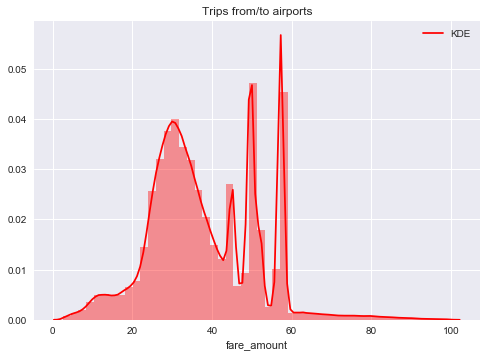

In [38]:
# Create distplot for each individual airport
# not ready

airport_names = {"jfk": 'JFK Airport', 
                 "ewr": 'Newark Liberty International Airport',
                 "lgr": 'LaGuardia Airport'}

# Create distplot for all airports
if show_diagrams == 1:
    ax = sns.distplot(df_airport_trips[df_airport_trips['fare_amount']<100]['fare_amount'], color="r",
                     kde_kws={"label": "KDE"})
    ax.set_title('Trips from/to airports');

In [39]:
# create a dataframe without airport trips
df_len_old = df.shape[0]
df = df[(df['to_airport'].isnull()) & (df['from_airport'].isnull())]
df.drop(columns=['from_airport', 'to_airport'], inplace=True)
df_len_new = df.shape[0]

output_data_manipulation(df_len_old, df_len_new)

Data frame manipulation:

  Old size: 52143044
  Deleted:   2706098
  ------------------
  New size: 49436946


# Extract date, time information

In [40]:
# Extract year, month, day, weekday and hour from 'pickup_datetime'

df['year'] = df['pickup_datetime'].dt.year
df['year'] = df['year'].astype('uint16')

df['month'] = df['pickup_datetime'].dt.month
df['month'] = df['month'].astype('uint8')

df['day'] = df['pickup_datetime'].dt.day
df['day'] = df['day'].astype('uint8')

df['wday'] = df['pickup_datetime'].dt.weekday
df['wday'] = df['wday'].astype('uint8')

df['hour'] = df['pickup_datetime'].dt.hour
df['hour'] = df['hour'].astype('uint8')

# Check

In [48]:
df.describe()

NameError: name 'df' is not defined

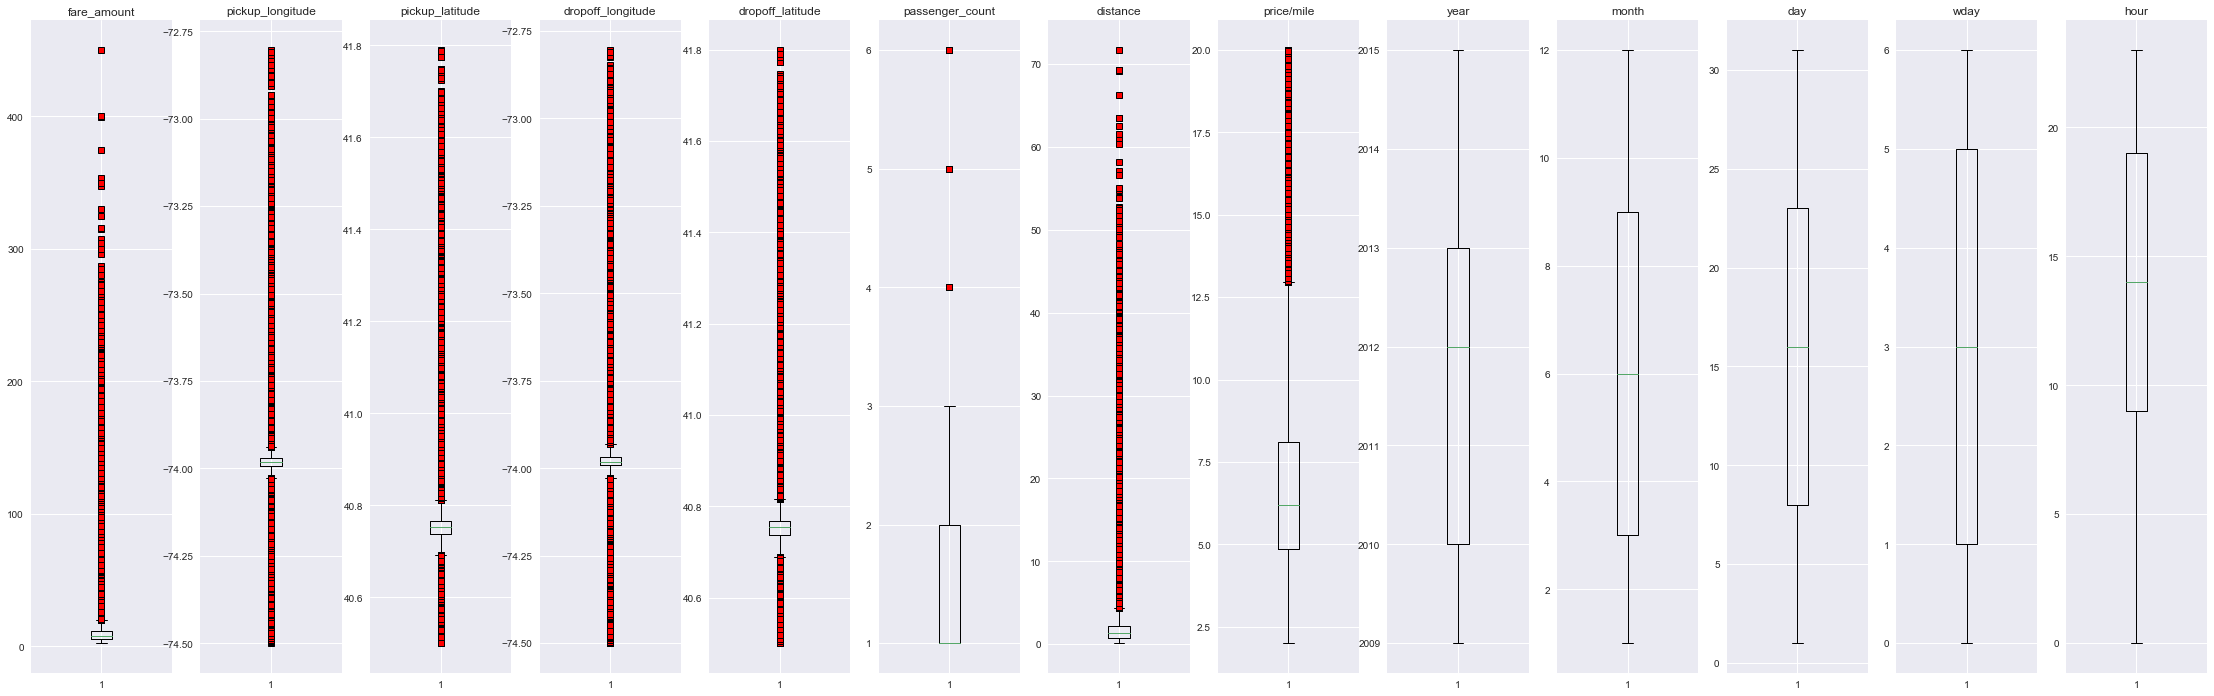

In [42]:
# Boxplot of all numeric columns
if show_diagrams == 1:
    # generate a list with the names of all numeric columns
    num_columns = df.select_dtypes(include=np.number).columns.tolist()
    num_columns_len = len(num_columns)

    # marker for outliers
    red_square = dict(markerfacecolor='r', marker='s')

    # set counter
    cnt=0

    # draw boxplots
    fig, ax = plt.subplots(1, num_columns_len,figsize=(num_columns_len*3, 12))

    for i in num_columns:
        ax[cnt].boxplot(df[i], flierprops=red_square)
        ax[cnt].set_title(i)
        cnt+=1

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49436946 entries, 0 to 55423855
Data columns (total 14 columns):
 #   Column             Dtype              
---  ------             -----              
 0   fare_amount        float32            
 1   pickup_datetime    datetime64[ns, UTC]
 2   pickup_longitude   float32            
 3   pickup_latitude    float32            
 4   dropoff_longitude  float32            
 5   dropoff_latitude   float32            
 6   passenger_count    uint8              
 7   distance           float32            
 8   price/mile         float32            
 9   year               uint16             
 10  month              uint8              
 11  day                uint8              
 12  wday               uint8              
 13  hour               uint8              
dtypes: datetime64[ns, UTC](1), float32(7), uint16(1), uint8(5)
memory usage: 2.3 GB


# Write feather-file

In [44]:
# Reset index is necessary for writing the dataframe to feather file
df.reset_index(inplace = True)

In [45]:
# Write cleaned dataframe to feather file, about 2.3Gb. 
if write_to_feather == 1:
    df.to_feather(output_file)

# Delete dataframes to release memory

In [46]:
alldfs = [var for var in dir() if isinstance(eval(var), pd.core.frame.DataFrame)]
print(alldfs)

['_', '_41', '_5', '_6', '_8', 'df', 'df_airport_trips', 'missing_values']


In [47]:
del df
del df_airport_trips
del missing_values